# Introduction à l'apprentissage automatique - TP6 exercice 1

<br>

Le but de ce TP est de découvrir une application de la vision par ordinateur, la classification d'images.

On utilisera un sous-ensemble de la [base de données Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), constitué d'images appartenant à 6 catégories, disponible [à cette URL](https://members.loria.fr/FSur/enseignement/apprauto/Caltech_small2.zip).

<br>
Commencez par charger la base réduite dans un répertoire local, et visualisez les images qu'elle contient.

<br>

Le but est de prédire la catégorie d'une image de la base de test, connaissant les catégories auxquelles appartiennent les images de la base d'apprentissage. Il s'agit donc d'un problème de classification supervisée.

Les images ont des tailles différentes, de l'ordre de 300x200 pixels. Ce sont des images en couleur, un pixel est donc décrit par un triplet de composantes Rouge, Vert, Bleu. Les composantes prennent des valeurs entre 0 et 255 (codage sur 8 bits), de manière à ce que (0,0,0) est le noir, (255,255,255) le blanc, (0,255,0) au vert "pur", etc. Chaque image est donc décrite par approximativement 3x300x200=120000 valeurs variant entre 0 et 255. 

Le défi est de réduire la dimensionnalité du problème, en extrayant de chaque image une information pertinente représentée dans un espace de dimension "raisonnable", commun à toutes les images. Nous allons utiliser une méthode inspirée de celle présentée dans [cet article](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.459.9821&rep=rep1&type=pdf) très célèbre de 1999: chaque image sera représentée par un vecteur de ${\mathbb R}^{48}$ obtenu en concaténant les histogrammes sur 16 "baquets" (_bins_) de chaque composante R,V,B. Chaque composante étant codée sur 256 valeurs, un histogramme est donc obtenu en calculant la fréquence des valeurs entre 0 et 15, la fréquence des valeurs entre 16 et 31... d'où un histogramme sur 16 baquets.

<br>

On commence par importer des bibliothèques, et définir une fonction de visualisation de la base de test qui nous sera utile pour visualiser les performances des classifieurs.

In [1]:
from sklearn import svm, model_selection, neural_network, neighbors, linear_model, metrics, cluster
from sklearn.metrics.pairwise import chi2_kernel
import numpy as np
#import time
import os
import matplotlib.pyplot as plt

def display_test(X_image_test,X_size_test,Y_test,Y_test_pred,txt):
    # paramètres: 
    # X_image_test: tableau des images de test représentées par un vecteur ligne
    # X_size_test: tableau des tailles des images de test
    # Y_test: classes d'appartenance réelles
    # Y_test_pred: classes prédites
    # txt: légende de la figure
    plt.figure(figsize=[16,10])    
    for n in range(60):
        plt.subplot(6,10,n+1,xticks=[],yticks=[])
        plt.imshow(X_image_test[n].reshape(X_size_test[n]),cmap='gray')
        if Y_test_pred[n]==Y_test[n]:
            plt.text(0.1,0.1,str(Y_test_pred[n])+' / '+str(Y_test[n]),fontsize=8,bbox=dict(facecolor='white', alpha=1))
        else:
            plt.text(0.1,0.1,str(Y_test_pred[n])+' / '+str(Y_test[n]),fontsize=8,bbox=dict(facecolor='red', alpha=1))
    plt.suptitle('prediction '+txt)
    plt.show();



<br>

La cellule suivante permet de lire les données et stocker l'information dans des tableaux. Constatez que chaque classe fournit 60 images d'apprentissage et 10 images de test.

In [4]:
# modifiez le chemin d'accès à vos données:
path="C:/Users/gadey/Documents/Aprentissage_auto/seance_6/Caltech_small2/" 

X_image_train=[] # tableau des images d'aprentissage, chaque ligne du tableau comprenant une image décrite ligne à ligne (voir la documentation de flatten dans numpy)
X_image_test=[]  # idem pour les images de test
X_size_train=[]  # tableau dont chaque ligne contient (nbre de lignes, nbre de colonnes) des images d'apprentissage
X_size_test=[]   # idem pour la base de test
X_train=[]       # tableau dont chaque ligne contient l'histogramme des niveaux de gris d'une image d'apprentissage
Y_train=[]       # tableau des classes d'appartenance des images
X_test=[]        # pour la base de test
Y_test=[]        # pour la base de test

y=0  # numéro de classe
for directory in os.listdir(path):
    count = 0 # indice de l'image traitée dans le répertoire courant
    print("%s  - classe: %d" % (directory,y))
    for file in os.listdir(path+directory):
        #img=np.mean(plt.imread(path+directory+"/"+file),-1)  # moyenne des canaux RGB de l'image couleur (image N&B)
        img=plt.imread(path+directory+"/"+file)
        imgflatten=np.array(img).flatten()
        if (count<60):
            X_size_train.append(img.shape)
            X_image_train.append(imgflatten)
            hR,bR=np.histogram(img[:,:,0],range=(0,255),density=True,bins=16)  # on calcule la fréquence des niveaux de gris dans l'image courante
            hG,bG=np.histogram(img[:,:,1],range=(0,255),density=True,bins=16)  # on calcule la fréquence des niveaux de gris dans l'image courante
            hB,bB=np.histogram(img[:,:,2],range=(0,255),density=True,bins=16)  # on calcule la fréquence des niveaux de gris dans l'image courante
            X_train.append(np.concatenate((hR,hG,hB)))       
            Y_train.append(y)
        else: 
            if (count<70):
                X_size_test.append(img.shape)
                X_image_test.append(imgflatten)
                hR,bR=np.histogram(img[:,:,0],range=(0,255),density=True,bins=16)  # on calcule la fréquence des niveaux de gris dans l'image courante
                hG,bG=np.histogram(img[:,:,1],range=(0,255),density=True,bins=16)  # on calcule la fréquence des niveaux de gris dans l'image courante
                hB,bB=np.histogram(img[:,:,2],range=(0,255),density=True,bins=16)  # on calcule la fréquence des niveaux de gris dans l'image courante
                X_test.append(np.concatenate((hR,hG,hB)))   
                Y_test.append(y)
        count=count+1
    y=y+1

airplanes  - classe: 0
brain  - classe: 1
butterfly  - classe: 2
Faces  - classe: 3
Motorbikes  - classe: 4
starfish  - classe: 5


Selon vous, pourquoi utilise-t-on `density=True`? 
(référez-vous à la documentatio de la fonction numpy [histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html))

La cellule suivante permet de visualiser une image et les histogrammes (fréquences empiriques) de chaque canal.

In [ ]:
density = true : pas compris.

360 observations dans la base d'apprentissage, chacune est décrite par un vecteur de dimension 48


Text(0.5, 1.0, 'histogramme canal B')

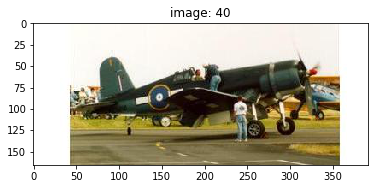

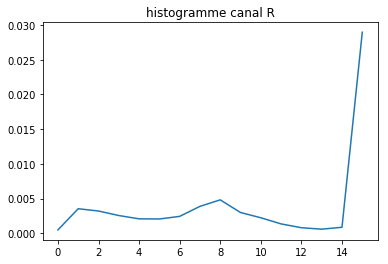

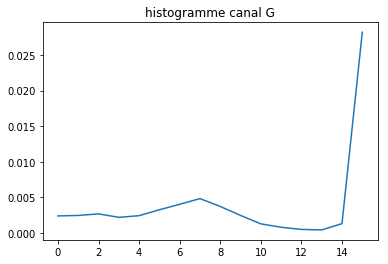

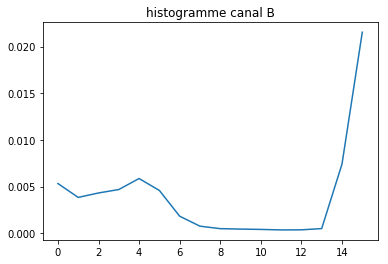

In [5]:
print("%d observations dans la base d'apprentissage, chacune est décrite par un vecteur de dimension %d" % (len(X_train), len(X_train[0])) )
# exemple: visualisation d'une image
n_image=40  # indice d'une image de la base d'apprentissage, essayez d'autres valeurs
plt.figure()
plt.imshow(X_image_train[n_image].reshape(X_size_train[n_image]))  # reshape permet de transformer la représentation "en ligne" d'une image en une représentation 2D de taille nbre de lignes x nbre de colonnes
plt.title("image: %d" % n_image)
plt.figure()
plt.plot(X_train[n_image][0:16])
plt.title("histogramme canal R")
plt.figure()
plt.plot(X_train[n_image][16:32])
plt.title("histogramme canal G")
plt.figure()
plt.plot(X_train[n_image][32:48])
plt.title("histogramme canal B")

Testez différents algorithmes de classification: SVM, MLP, NN, LR.

<br>

* Pour les SVM, vous testerez les noyaux 'linear', 'rbf', et 'chi2_kernel', dont vous retrouverez les formules dans la documentation.

On peut utiliser une SVM avec un noyau du $\chi^2$ (on sait que cette métrique est bien adaptée à la comparaison d'histogrammes d'après le cours de statistique) à l'aide de:
```python 
SVM = svm.SVC(kernel=chi2_kernel)
``` 
avec l'import préalable:
```python
from sklearn.metrics.pairwise import chi2_kernel
```


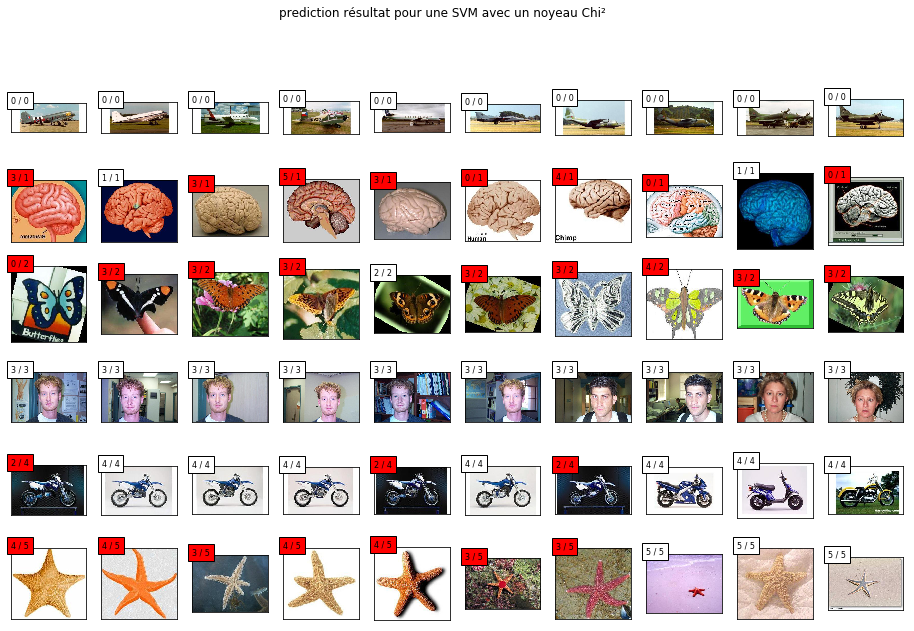

In [8]:
#code SVM

from sklearn.metrics.pairwise import chi2_kernel

SVM = svm.SVC(kernel=chi2_kernel)
SVM.fit(X_train, Y_train)
Y_test_pred = SVM.predict(X_test)
display_test(X_image_test,X_size_test,Y_test,Y_test_pred, "résultat pour une SVM avec un noyeau Chi²")

In [ ]:
<br>

* Pour les MLP, vous testerez un réseau à une couche cachée à 5 neurones et un autre avec deux couches cachées à 5 neurones, dont vous fixerez les hyperparamètres (`alpha`, `max_iter` par `GridSearchCV`).

C:\Users\gadey\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Meilleur estimateur trouvé:
MLPClassifier(activation='tanh', alpha=6.309573444801904e-05,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(5, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=501.18723362727303, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Meilleurs paramètres:
{'alpha': 6.309573444801904e-05, 'max_iter': 501.18723362727303}


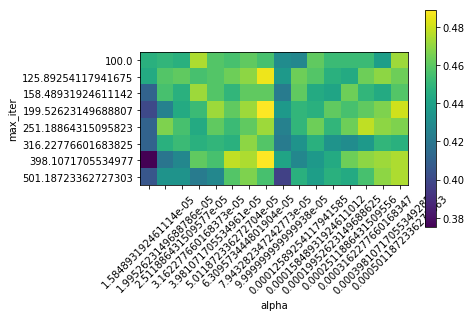

In [24]:
from sklearn.neural_network import MLPClassifier

alpha_range=10**(np.arange(-4.8,-3.2,.1))
max_iter_range=10**(np.arange(2,2.7,.1)) 
# alpha_range=np.arange(0.00005,0.00015,0.0001)
# max_iter_range=np.arange(100,500,50)
parameters = { 'alpha': alpha_range, 'max_iter':max_iter_range }
SVM = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,5), random_state=1, activation = 'tanh')
gridsearch=model_selection.GridSearchCV(SVM, parameters)
gridsearch.fit(X_train,Y_train)
print("Meilleur estimateur trouvé:")
print(gridsearch.best_estimator_)
print("Meilleurs paramètres:")
print(gridsearch.best_params_)

scores = gridsearch.cv_results_['mean_test_score'].reshape(len(max_iter_range),len(alpha_range))
# plt.figure(figsize=[10,10])
plt.imshow(scores)
plt.xlabel('alpha')
plt.ylabel('max_iter')
plt.xticks(np.arange(len(alpha_range)), alpha_range, rotation=45)
plt.yticks(np.arange(len(max_iter_range)), max_iter_range)
plt.colorbar()
plt.show();

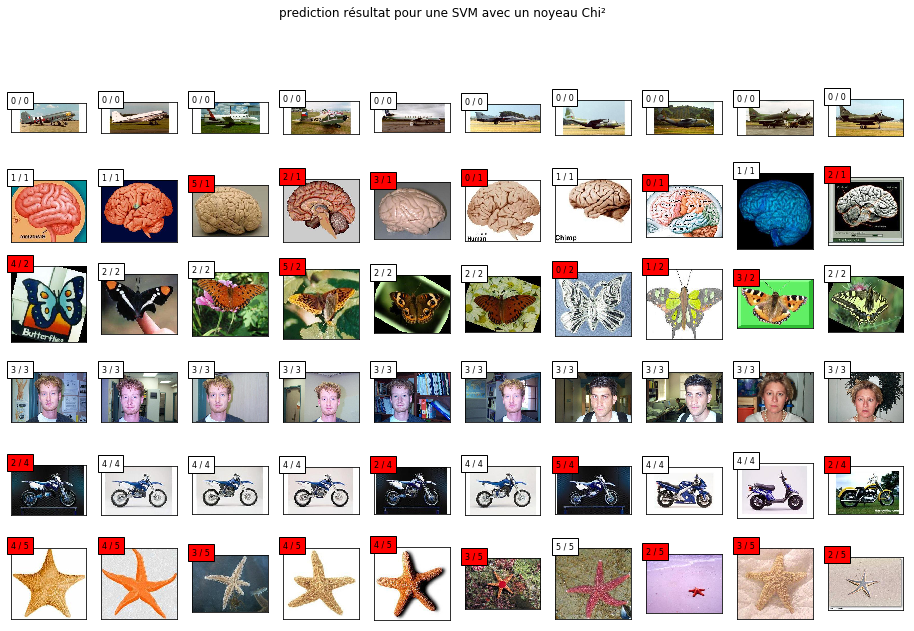

In [28]:
#Version MLP 1 couche cachée 5 neurones
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=6.3095e-5, max_iter = 400, hidden_layer_sizes=(10, 10, 10), random_state=1, activation = "tanh")
clf.fit(X_train, Y_train)
Y_test_pred = clf.predict(X_test)
display_test(X_image_test,X_size_test,Y_test,Y_test_pred, "résultat pour une SVM avec un noyeau Chi²")

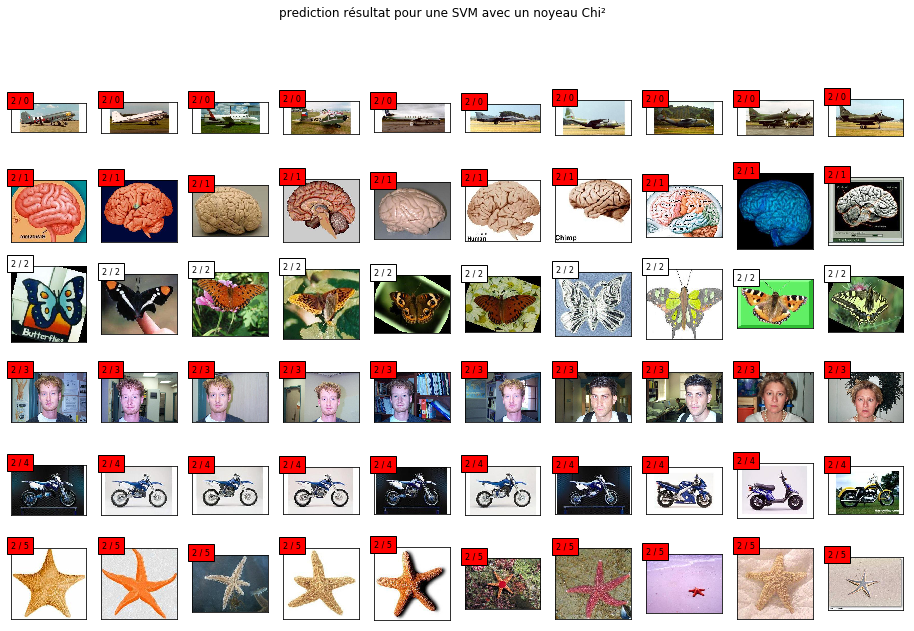

In [29]:
#Version MLP 2 couches cachées 5 neurones
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,10), random_state=1)
clf.fit(X_train, Y_train)
Y_test_pred = clf.predict(X_test)
display_test(X_image_test,X_size_test,Y_test,Y_test_pred, "résultat pour une SVM avec un noyeau Chi²")

In [ ]:
<br>

Pour chaque classifieur, vous afficherez le score de classification sur la base de test, la matrice de confusion, et la visualisation de la classification obtenue à l'aide de la fonction `display_test` fournie.

<br> 

Quel est le score de classification "minimal" auquel se comparer ?




Quel algorithme d'apprentissage présente les meilleures performances ?

Quelle est la classe la plus "facile" à reconnaître, et pourquoi ? La plus difficile ?

Que dire des biais de la base d'apprentissage ?


<br>

## Question bonus 1

Comme on le voit dans l'[article](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.459.9821&rep=rep1&type=pdf) dont on s'inspire, la méthode proposée est en fait de considérer l'histogramme des triplets R,G,B en chaque pixel. Chaque image est donc décrite par un vecteur de ${\mathbb R}^{16^3} = {\mathbb R}^{4096}$.
Cf section III A de l'article. L'avantage est de tenir compte des corrélations entre composantes R,G,B.

Si vous le souhaitez, vous pouvez adapter le carnet Jupyter d'ici la semaine prochaine pour utiliser cette méthode et vérifier si les performances de classification sont meilleures. N'hésitez pas à m'envoyer votre travail (fichiers `ipynb` et exports `html` ou `pdf` du résultat), un bonus sera accordé pour l'évaluation.

Remarquez également que différents noyaux sont testés pour les SVM de l'article de Chapelle et al. Vous pouvez  tester certains d'entre eux.


<br>

## Question bonus 2

Adaptez le travail à la [base Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) entière.

<br>

<br>

## Remarques

Cette méthode correspond à l'état de l'art scientifique à la fin des années 1990.

En 2004-2005 sont apparus de nouveaux algorithmes basés sur la notion de "sac de mots visuels" dont une description accessible est [disponible ici](https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb) par exemple. Il s'agit d'une adaptation aux images des sacs de mots que l'on vous a présentés en [TP 1 exercice 2](https://members.loria.fr/FSur/enseignement/apprauto/TP1_ex2_sujet.html).

Depuis 2012, les méthodes basées sur les [réseaux de neurones convolutionnels](https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4) obtiennent les meilleurs résultats.